In [84]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2

from tqdm import tqdm

from PIL import Image

import sys

sys.path.append("..")

from utils.dcm_utils import *
from utils.nii_utils import *
from utils.train_utils import *
from utils.xray_utils import *

%load_ext autoreload
%autoreload 2

In [38]:
DATA_DIR = "/Volumes/SSD970/"
DATASET_DIR = "../../dataset/"
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, "train_images")
XRAY_IMAGE_DIR = os.path.join(DATA_DIR, "xray_images")

xray_df = pd.read_csv(os.path.join(DATASET_DIR, "meta_xray.csv"))
xray_df = xray_df.set_index("UID")
xray_df.head()

,direction,z_spacing,pixel_spacing,aspect,width,height
UID,,,,,,
1.2.826.0.1.3680043.10005,0,0.625,0.298828,2.091504,512,512
1.2.826.0.1.3680043.10005,1,0.625,0.298828,2.091504,512,541
1.2.826.0.1.3680043.10005,2,0.625,0.298828,2.091504,512,541
1.2.826.0.1.3680043.10014,0,0.800,0.234000,3.418803,512,512
1.2.826.0.1.3680043.10014,1,0.800,0.234000,3.418803,512,882


(340, 512)


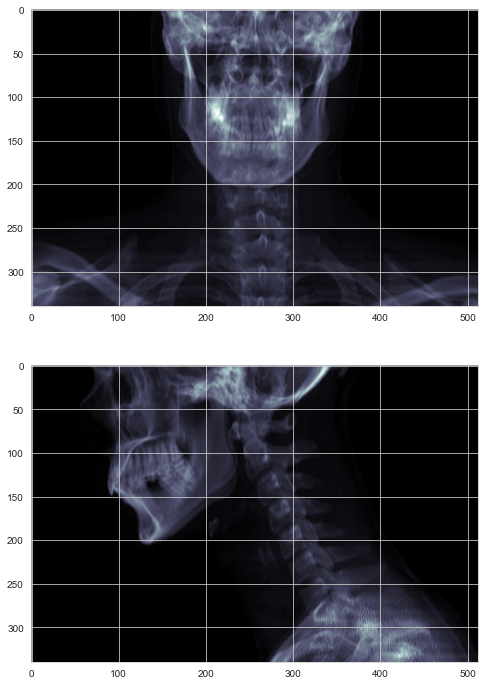

In [55]:
patient_id = "1.2.826.0.1.3680043.1363"
patient_dir = os.path.join(XRAY_IMAGE_DIR, patient_id)

xray = xray_df.loc[patient_id]
pixel_spacing = xray.pixel_spacing[0]

coronal = Image.open(os.path.join(patient_dir, "coronal.jpeg"))
arr = np.asarray(coronal) / 255
print(arr.shape)

sagittal = Image.open(os.path.join(patient_dir, "sagittal.jpeg"))


_, axs = plt.subplots(2, 1, figsize=(24, 12))

axs[0].imshow(arr, cmap='bone')
axs[1].imshow(sagittal, cmap='bone')

y axis 에서 어떤 threshold 보다 큰 량의 개수 통계하기

Text(0.5, 1.0, 'std of coronal')

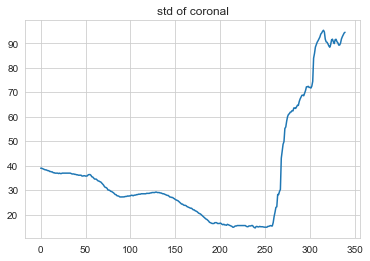

In [53]:
std_list = []
for i, slice_idx in enumerate(range(arr.shape[0])):
    # slice_idx = 100
    threshold = 0.1

    slice = arr[slice_idx, :]
    idx = np.greater(slice, threshold).nonzero()[0]
    std_list.append(idx.std())
std_arr = np.asarray(std_list)
std_arr = std_arr * pixel_spacing
plt.plot(std_arr)
plt.title("std of coronal")

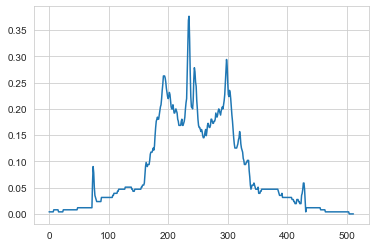

In [7]:
plt.plot(arr[512, :] / 255)

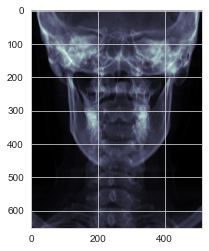

In [9]:
plt.imshow(arr, cmap='bone')

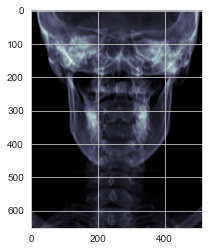

In [12]:
plt.imshow(np.clip(arr, a_min=0.05 * 255, a_max=255), cmap='bone')

In [27]:
np.mean(np.greater(arr[512, :], 10).nonzero())

242.69856459330143

threshold (10) 보다 큰 데이터들의 분포의 중심을 찾기

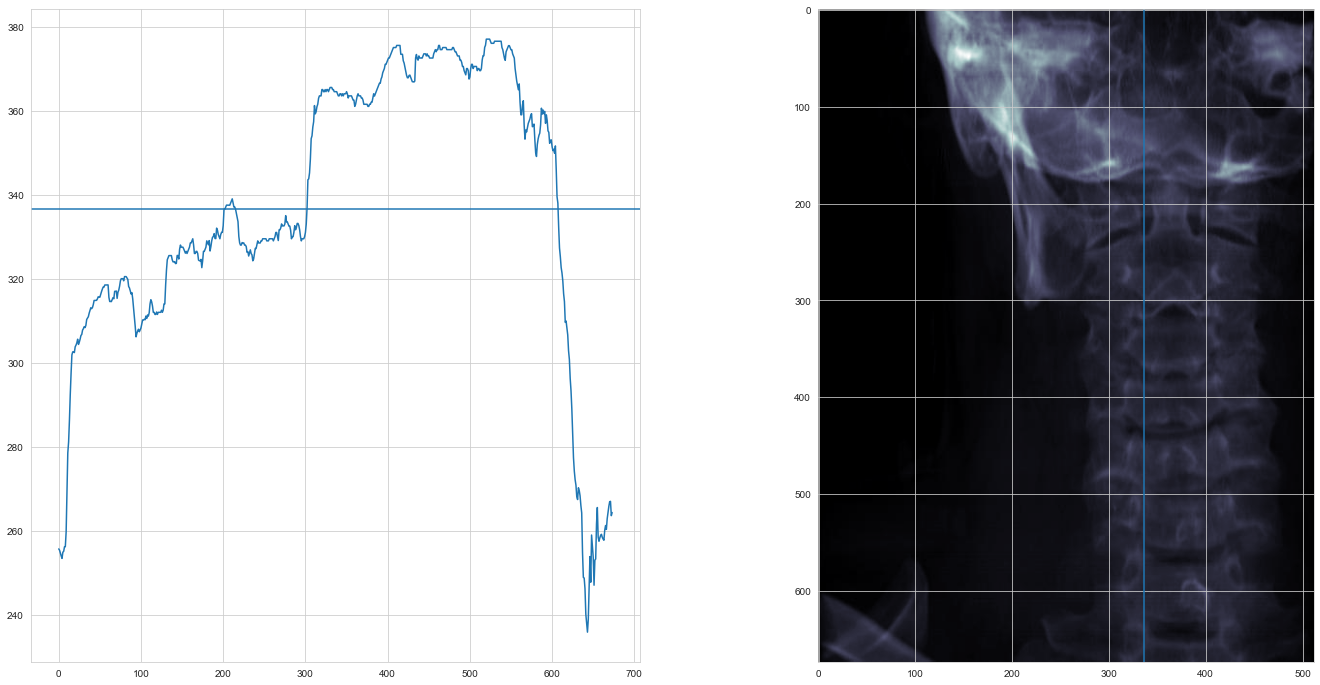

In [84]:
threshold = 20

patient_id = "1.2.826.0.1.3680043.632"
patient_dir = os.path.join(XRAY_IMAGE_DIR, patient_id)

coronal = Image.open(os.path.join(patient_dir, "coronal.jpeg"))
arr = np.asarray(coronal)

centers = np.zeros(arr.shape[0])

# 각각 slice 의 center 를 찾는다
for slice in range(arr.shape[0]):
    centers[slice] = np.mean(np.greater(arr[slice, :], threshold).nonzero())

_, axs = plt.subplots(1, 2, figsize=(24, 12))
center = np.mean(centers)
axs[0].axhline(center)
axs[0].plot(centers)
axs[1].imshow(arr, cmap='bone')
axs[1].axvline(center)

평균을 취했을때 한쪽으로 기운다. 이미지 자체가 대칭이 안될때, 그래서 가운데 60% 취해본다.

length of slices 205


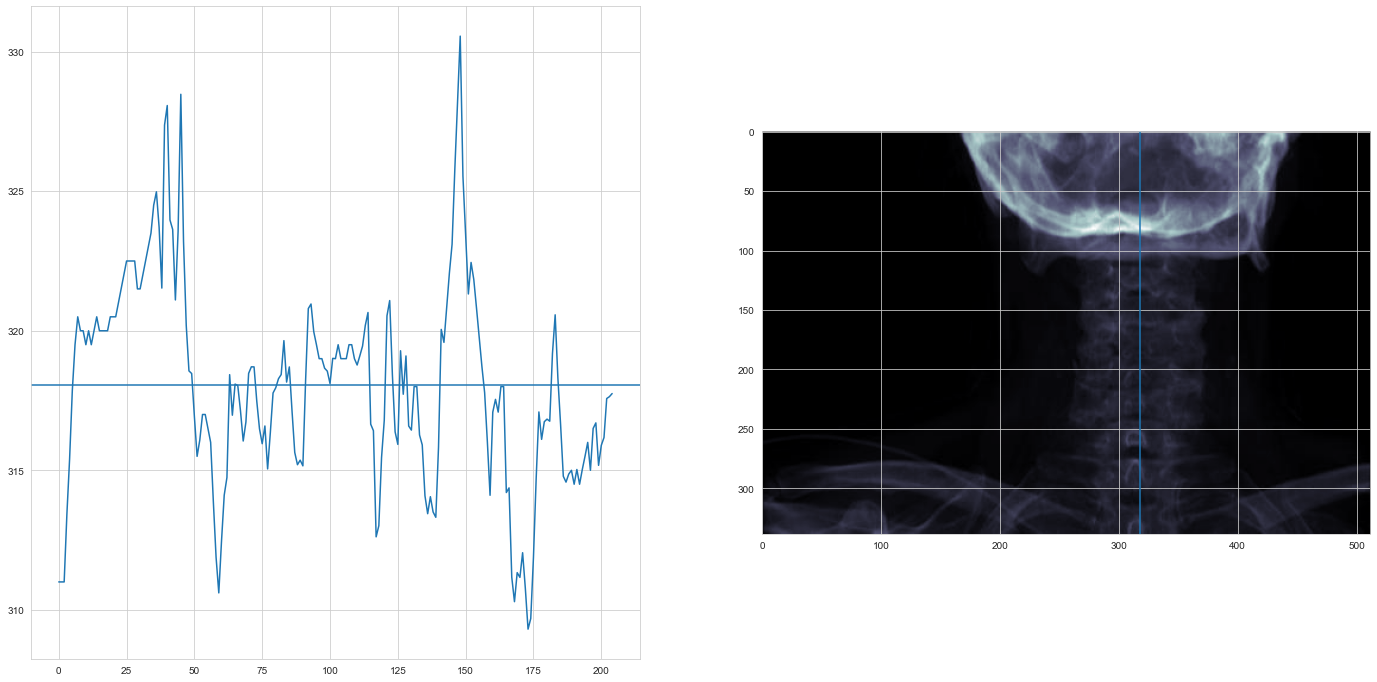

In [70]:

def find_coronal_center(patient_id, xray_dir, threshold = 30):


    patient_dir = os.path.join(XRAY_IMAGE_DIR, patient_id)

    coronal = Image.open(os.path.join(patient_dir, "coronal.jpeg"))
    arr = np.asarray(coronal)

    # 각각 slice 의 center 를 찾는다
    num_slices = arr.shape[0]
    slices = list(range(num_slices))[int(num_slices * 0.2) : -int(num_slices * 0.2)]
    print(f"length of slices {len(slices)}")
    centers = np.zeros(len(slices))
    for i, slice in enumerate(slices):
        centers[i] = np.mean(np.greater(arr[slice, :], threshold).nonzero())

    _, axs = plt.subplots(1, 2, figsize=(24, 12))
    center = np.mean(centers)
    axs[0].axhline(center)
    axs[0].plot(centers)
    axs[1].imshow(arr, cmap='bone')
    axs[1].axvline(center)



patient_id = "1.2.826.0.1.3680043.8024"


threshold 를 넘는 가장 왼쪽과 오른쪽 점의 평균을 찾는다.

length of slices 136
center 336.0882352941176


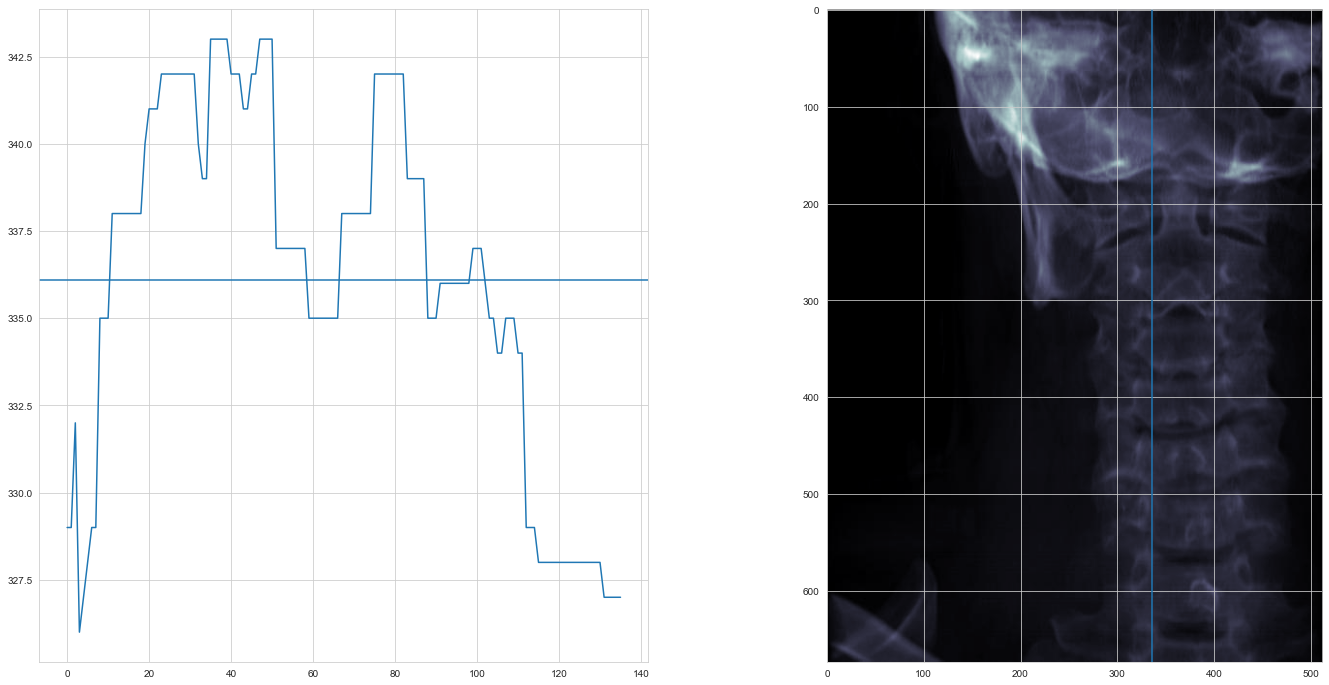

In [66]:
threshold = 10


patient_id = "1.2.826.0.1.3680043.632"
patient_dir = os.path.join(XRAY_IMAGE_DIR, patient_id)

coronal = Image.open(os.path.join(patient_dir, "coronal.jpeg"))
arr = np.asarray(coronal)

# 각각 slice 의 center 를 찾는다
num_slices = arr.shape[0]
slices = list(range(num_slices))[int(num_slices * 0.4) : -int(num_slices * 0.4)]
print(f"length of slices {len(slices)}")
centers = []
for i, slice in enumerate(slices):
    idx = np.greater(arr[slice, :], threshold).nonzero()

    # print(np.min(idx))
    centers.append((np.min(idx) + np.max(idx)) // 2)

_, axs = plt.subplots(1, 2, figsize=(24, 12))

center = np.mean(centers)
print(f"center {center}")
axs[0].axhline(center)
axs[0].plot(centers)
axs[1].imshow(arr, cmap='bone')
axs[1].axvline(center)

length of slices 136
center 326


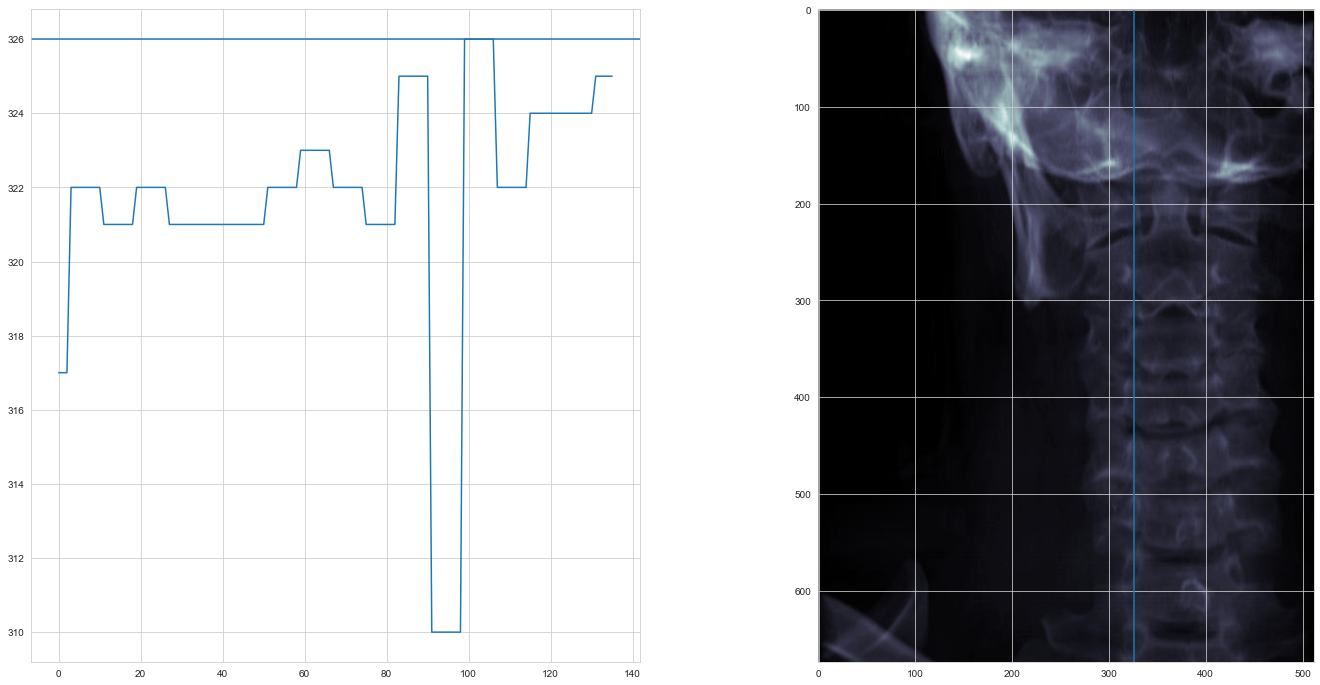

In [68]:
threshold = 5

patient_id = "1.2.826.0.1.3680043.632"
patient_dir = os.path.join(XRAY_IMAGE_DIR, patient_id)

coronal = Image.open(os.path.join(patient_dir, "coronal.jpeg"))
arr = np.asarray(coronal)

# 각각 slice 의 center 를 찾는다
num_slices = arr.shape[0]
slices = list(range(num_slices))[int(num_slices * 0.4) : -int(num_slices * 0.4)]
print(f"length of slices {len(slices)}")
centers = []
for i, slice in enumerate(slices):
    idx = np.greater(arr[slice, :], threshold).nonzero()

    # print(np.min(idx))
    centers.append((np.min(idx) + np.max(idx)) // 2)

_, axs = plt.subplots(1, 2, figsize=(24, 12))

center = np.max(centers)
print(f"center {center}")
axs[0].axhline(center)
axs[0].plot(centers)
axs[1].imshow(arr, cmap='bone')
axs[1].axvline(center)

In [16]:
slice_512 = arr[512, :]
slice_512[slice_512 < 13] = 0
slice_512

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 15, 23, 20, 13,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 13, 13, 14, 14, 14, 15, 19, 23, 25, 24, 23, 24, 24, 24, 26,
       29, 30, 30, 30, 31, 32, 31, 33, 38, 42, 45, 46, 47, 46, 46, 48, 50,
       52, 53, 56, 60, 63, 67, 67, 67, 66, 64, 61, 59, 57, 56, 57, 59, 58,
       55, 52, 51, 51, 53, 51, 49, 49, 50, 51, 50, 49, 46, 45, 43, 43, 43,
       43, 45, 46, 43, 43

threshold 를 초과하는 픽셀 개수를 counting 하기


(520, 512)


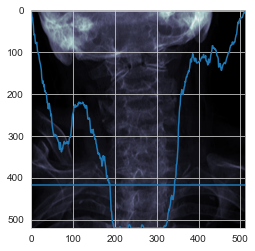

In [81]:
def count_coronal(patient_id, xray_image_dir, threshold=20):

    patient_dir = os.path.join(xray_image_dir, patient_id)

    coronal = Image.open(os.path.join(patient_dir, "coronal.jpeg"))
    arr = np.asarray(coronal)

    num_columns = arr.shape[1]

    column_counts = []
    for i in range(num_columns):
        column = arr[:, i]
        idx = np.greater(column, threshold).nonzero()[0]
        column_counts.append(len(idx))

    return column_counts, arr

threshold = 20
patient_id = "1.2.826.0.1.3680043.27262"
column_counts, arr = count_coronal(patient_id, XRAY_IMAGE_DIR, threshold)
print(arr.shape)
y_line = arr.shape[0] * 0.8
plt.axhline(y=y_line)
plt.plot(column_counts)
plt.imshow(arr, cmap='bone')

### Sagittal
위에서 찾은 x 를 통해 sagittal image 를 얻고
그 sagittal 에서 왼쪽 라인을 따라가 본다.

In [85]:
UID = "1.2.826.0.1.3680043.2289"

center = find_coronal_center(UID, XRAY_IMAGE_DIR)

265

In [90]:

imgs, image_positions, image_orientations, pixel_spacings, slice_thicknesses, is_flip = read_patient_dcm(os.path.join(TRAIN_IMAGE_DIR, UID))
imgs = normalize_hu(imgs)

aspect = calculate_aspects(image_positions, pixel_spacings)

211
(211, 3)


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_aspect'

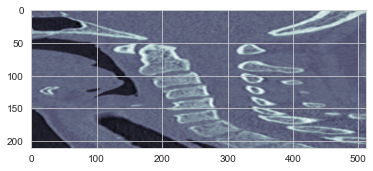

In [91]:
sagittal = imgs[:, :, center]
plt.imshow(sagittal, cmap='bone')
# plt.set_aspect(aspect)

In [93]:
sagittal.max()

0.9636485280999108

22.364928909952607


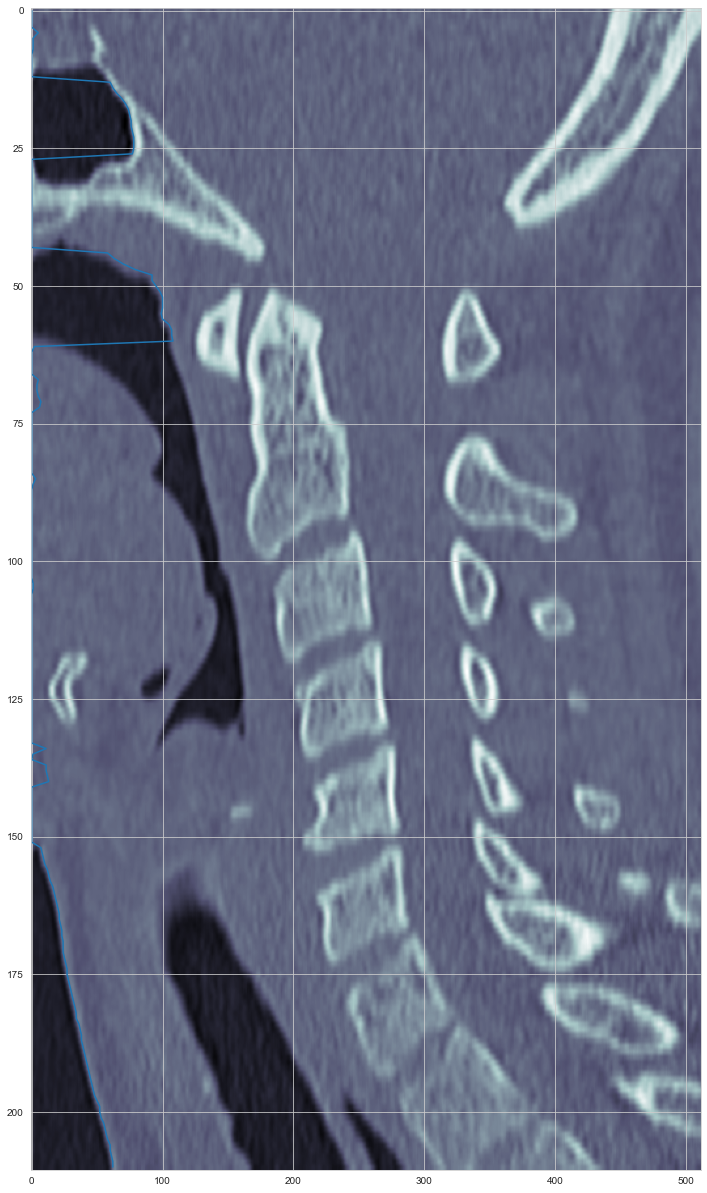

In [123]:
sagittal_threshold = 0.5
left_points = []
for row in range(sagittal.shape[0]):
    idx = np.greater(sagittal[row, :], sagittal_threshold).nonzero()[0]
    # print(len(idx))
    left_point = idx[0] if len(idx) > 0 else 0
    left_points.append(left_point)
print(np.mean(left_points))
fig = plt.figure(figsize=(6, 12))

ax = fig.add_subplot()

# plt.figure(figsize=(12, 24))
ax.imshow(sagittal, cmap='bone')
ax.set_aspect(aspect)
ax.plot(left_points, np.arange(len(left_points)))

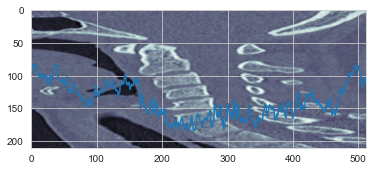

In [129]:
threshold = 0.5
num_columns = sagittal.shape[1]

column_counts = np.zeros(num_columns)
for i in range(num_columns):
    column = sagittal[:, i]
    idx = np.greater(column, threshold).nonzero()[0]
    column_counts[i] = len(idx)
plt.imshow(sagittal, cmap='bone')

plt.plot(column_counts)